In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import feature.util as feature_util
import pyBigWig
import torch
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define paths for the model and data of interest

In [3]:
model_type = "binary"

In [4]:
# Shared paths/constants
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
raw_data_base_path = "/users/amtseng/att_priors/data/raw/"
proc_data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
tfm_results_path = "/users/amtseng/att_priors/results/tfmodisco/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [5]:
# SPI1
condition_name = "SPI1-1task"
files_spec_path = os.path.join(proc_data_base_path, "ENCODE_TFChIP/%s/config/SPI1-1task/SPI1-1task_training_paths.json" % model_type)
num_tasks = 1
num_strands = 2
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
task_index = None
motif_path = "/users/amtseng/att_priors/results/SPI1_motifs/homer_motif1_trimmed.motif"

# gc_prob = 0.50
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/2/model_ckpt_epoch_3.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/2/model_ckpt_epoch_5.pt" % gc_prob)

# gc_prob = 0.51
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/3/model_ckpt_epoch_4.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/3/model_ckpt_epoch_4.pt" % gc_prob)

# gc_prob = 0.52
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/3/model_ckpt_epoch_5.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/3/model_ckpt_epoch_5.pt" % gc_prob)

# gc_prob = 0.53
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/2/model_ckpt_epoch_5.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/1/model_ckpt_epoch_4.pt" % gc_prob)

gc_prob = 0.54
noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/3/model_ckpt_epoch_3.pt" % gc_prob)
prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/2/model_ckpt_epoch_5.pt" % gc_prob)

# gc_prob = 0.55
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/2/model_ckpt_epoch_1.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/2/model_ckpt_epoch_1.pt" % gc_prob)

# gc_prob = 0.60
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/2/model_ckpt_epoch_1.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/2/model_ckpt_epoch_2.pt" % gc_prob)

# gc_prob = 0.80
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/1/model_ckpt_epoch_1.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/6/model_ckpt_epoch_1.pt" % gc_prob)

# gc_prob = 1.00
# noprior_model_path = os.path.join(model_base_path, "SPI1-1task_simgc%0.2f/1/model_ckpt_epoch_1.pt" % gc_prob)
# prior_model_path = os.path.join(model_base_path, "SPI1-1task_prior_simgc%0.2f/1/model_ckpt_epoch_1.pt" % gc_prob)

In [6]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [7]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [8]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model. We also create a loader for the GC content

In [9]:
sim_seq_generator = feature_util.StatusToSimulatedSeq(
    input_length, motif_path, 0, gc_prob
)

In [10]:
def input_func(bins):
    return sim_seq_generator(np.ones(len(bins))), np.empty((len(bins), num_tasks)), np.empty((len(bins), 3), dtype=object)

In [11]:
at_prob = 1 - gc_prob
background_freqs = np.array([at_prob, gc_prob, gc_prob, at_prob]) / 2
def pfm_to_pwm(pfm, pseudocount=0.001):
    """
    Converts and L x 4 PFM into an L x 4 PWM.
    """
    num_bases = pfm.shape[1]
    # Incorporate pseudocount by adding it to every element and renormalizing
    pfm_norm = (pfm + pseudocount) / (np.sum(pfm, axis=1, keepdims=True) + (num_bases * pseudocount))
    return np.log2(pfm_norm / np.expand_dims(background_freqs, axis=0))

In [12]:
motif_pwm = pfm_to_pwm(feature_util.import_homer_motif(motif_path))

### Compute importances

In [13]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [14]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls,
            task_index=task_index
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, task_index=task_index
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [15]:
num_samples = 100
sample = np.arange(num_samples)

In [16]:
# Compute the importance scores and 1-hot seqs
imp_type = ("DeepSHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "DeepSHAP scores" else compute_gradients
noprior_imp_scores, _ = imp_func(noprior_model, sample)
prior_imp_scores, sample_input_seqs = imp_func(prior_model, sample)

In [17]:
def get_motif_mask(one_hot_seqs, pwm, score_thresh=0.7):
    rc_pwm = np.flip(pwm, axis=(0, 1))
    mask = np.zeros(one_hot_seqs.shape[:2], dtype=bool)
    for i, one_hot_seq in tqdm.notebook.tqdm(enumerate(one_hot_seqs), total=len(one_hot_seqs)):
        for j in range(one_hot_seq.shape[0] - len(pwm) + 1):
            match = np.sum(one_hot_seq[j : j + len(pwm)] * pwm) / len(pwm)
            rc_match = np.sum(one_hot_seq[j : j + len(rc_pwm)] * rc_pwm) / len(rc_pwm)
            if match >= score_thresh or rc_match >= score_thresh:
                mask[i, j : j + len(pwm)] = True
    return mask

In [18]:
def get_non_motif_gc(imp_scores, motif_mask):
    keep_mask = ~motif_mask
    gc_scores, at_scores, prod_scores = [], [], []
    for i, score_track in enumerate(imp_scores):
        # score = np.sum(np.abs(score_track[keep_mask[i]][:, 1:3]), axis=1) / np.max(score_track)
        
        gc_score = np.sum(score_track[keep_mask[i]][:, 1:3], axis=1) / np.max(score_track)
        at_score = (score_track[keep_mask[i]][:, 0] + score_track[keep_mask[i]][:, 3]) / np.max(score_track)
        gc_scores.append(np.nanmean(gc_score))
        at_scores.append(np.nanmean(at_score))
        prod_scores.append(np.nanmean(gc_score * at_score))
    return np.array(gc_scores), np.array(at_scores), np.array(prod_scores)

In [19]:
masks = get_motif_mask(sample_input_seqs, motif_pwm, score_thresh=0.9)

In [20]:
noprior_gc_scores, noprior_at_scores, noprior_prod_scores = get_non_motif_gc(noprior_imp_scores, masks)
prior_gc_scores, prior_at_scores, prior_prod_scores = get_non_motif_gc(prior_imp_scores, masks)

Average product without priors: -0.004363
Average product with priors: -0.007210
One-sided Wilcoxon test: W = 3120.000000, p = 0.979612


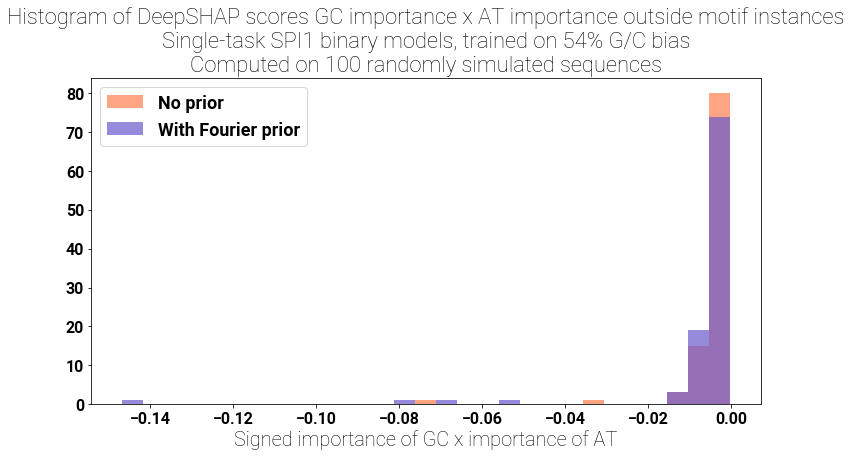

In [21]:
bin_num = 30
plt.figure(figsize=(12, 6))
title = "Histogram of %s GC importance x AT importance outside motif instances" % imp_type
title += "\nSingle-task SPI1 binary models, trained on %2.0f%% G/C bias" % (gc_prob * 100)
title += "\nComputed on %d randomly simulated sequences" % num_samples
plt.title(title)
plt.xlabel("Signed importance of GC x importance of AT")
all_vals = np.concatenate([noprior_prod_scores, prior_prod_scores])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
plt.hist(noprior_prod_scores, bins=bins, histtype="bar", label="No prior", color="coral", alpha=0.7)
plt.hist(prior_prod_scores, bins=bins, histtype="bar", label="With Fourier prior", color="slateblue", alpha=0.7)
plt.legend()

print("Average product without priors: %f" % np.nanmean(noprior_prod_scores))
print("Average product with priors: %f" % np.nanmean(prior_prod_scores))
w, p = scipy.stats.wilcoxon(noprior_prod_scores, prior_prod_scores, alternative="less")
print("One-sided Wilcoxon test: W = %f, p = %f" % (w, p))

Text(0, 0.5, 'Importance of GC x AT with Fourier prior')

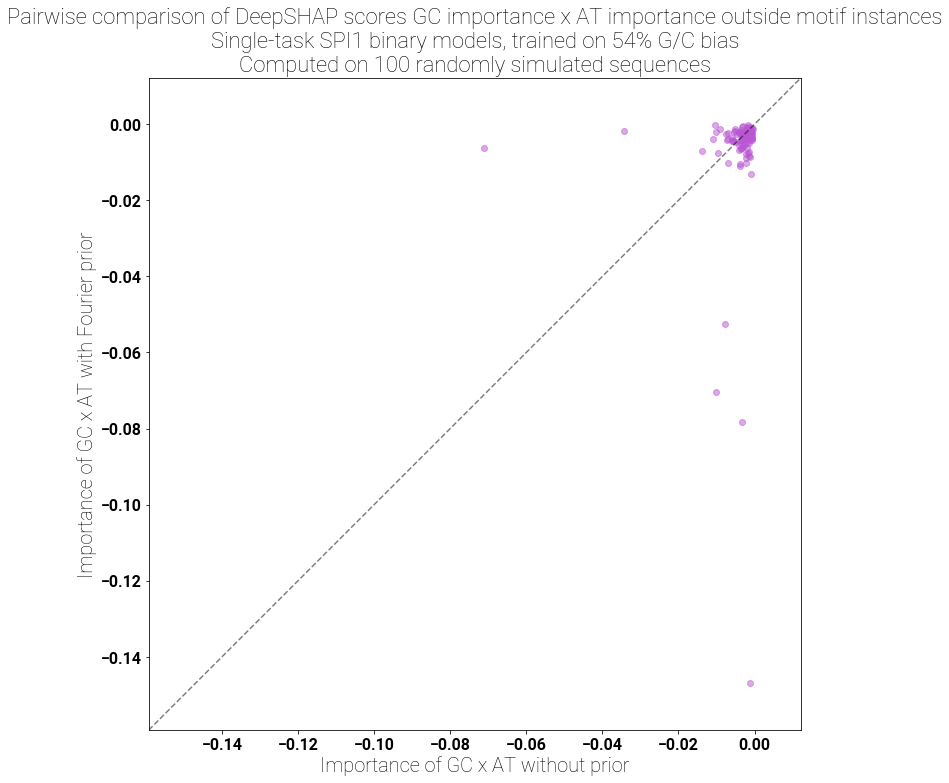

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(noprior_prod_scores, prior_prod_scores, color="mediumorchid", alpha=0.5)
title = "Pairwise comparison of %s GC importance x AT importance outside motif instances" % imp_type
title += "\nSingle-task SPI1 binary models, trained on %2.0f%% G/C bias" % (gc_prob * 100)
title += "\nComputed on %d randomly simulated sequences" % num_samples
plt.title(title)
limits = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(limits, limits, "--", alpha=0.5, color="black")
ax.set_aspect("equal")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.xlabel("Importance of GC x AT without prior")
plt.ylabel("Importance of GC x AT with Fourier prior")

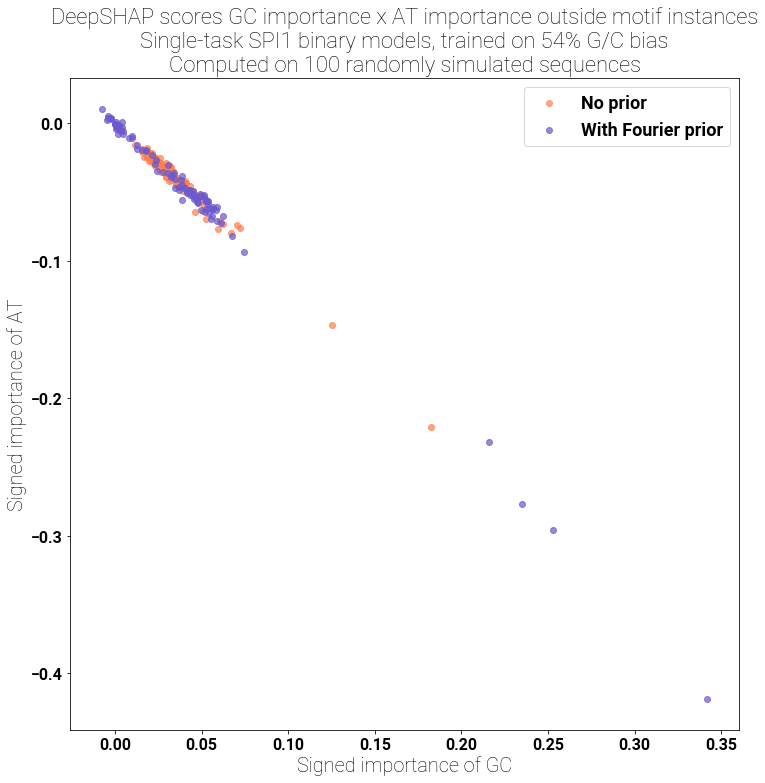

In [23]:
bin_num = 30
plt.figure(figsize=(12, 12))
title = "%s GC importance x AT importance outside motif instances" % imp_type
title += "\nSingle-task SPI1 binary models, trained on %2.0f%% G/C bias" % (gc_prob * 100)
title += "\nComputed on %d randomly simulated sequences" % num_samples
plt.title(title)
plt.xlabel("Signed importance of GC")
plt.ylabel("Signed importance of AT")
plt.scatter(noprior_gc_scores, noprior_at_scores, color="coral", alpha=0.7, label="No prior")
plt.scatter(prior_gc_scores, prior_at_scores, color="slateblue", alpha=0.7, label="With Fourier prior")
plt.legend()

In [24]:
def show_example(i, center_slice=slice(450, 550)):
    print(i)
    print("=========================")
    print("Without priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(noprior_imp_scores[i] * sample_input_seqs[i], axis=1), color="coral")
    plt.show()
    viz_sequence.plot_weights((noprior_imp_scores[i])[center_slice], subticks_frequency=1000)
    viz_sequence.plot_weights((noprior_imp_scores[i] * sample_input_seqs[i])[center_slice], subticks_frequency=1000)
    print("With priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(prior_imp_scores[i] * sample_input_seqs[i], axis=1), color="slateblue")
    plt.show()
    viz_sequence.plot_weights((prior_imp_scores[i])[center_slice], subticks_frequency=1000)
    viz_sequence.plot_weights((prior_imp_scores[i] * sample_input_seqs[i])[center_slice], subticks_frequency=1000)

35
Without priors:


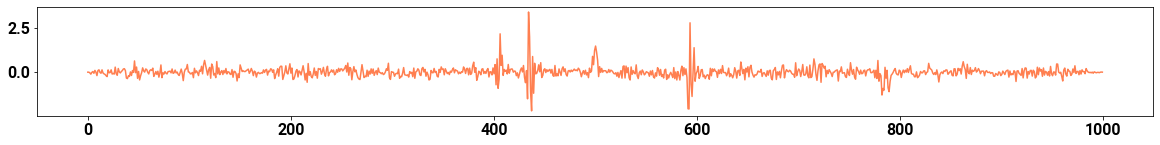

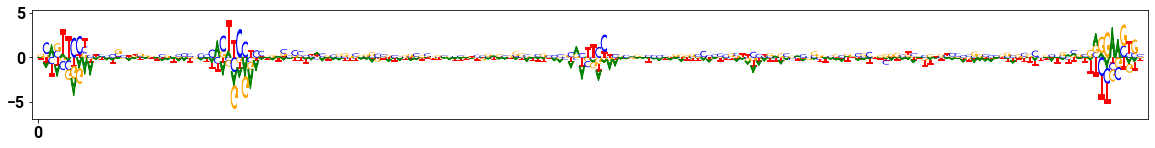

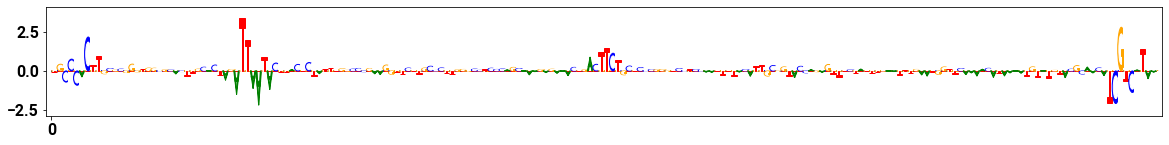

With priors:


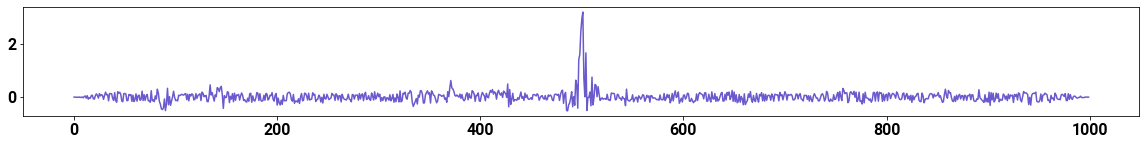

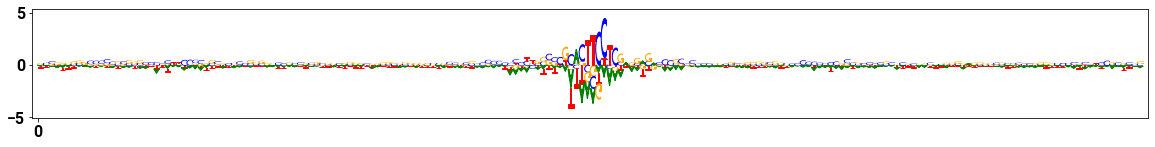

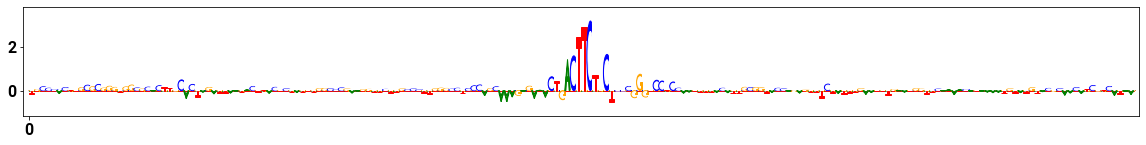

2
Without priors:


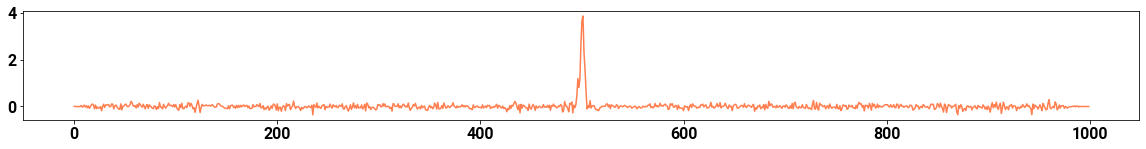

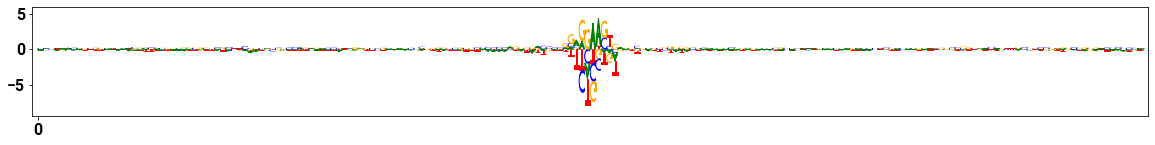

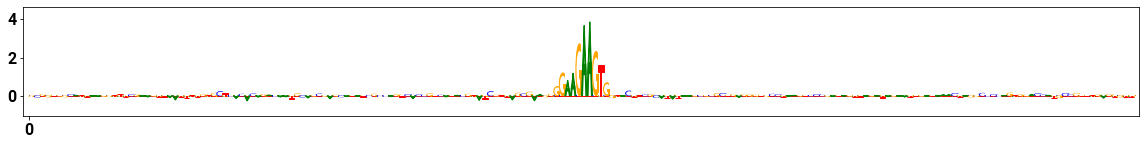

With priors:


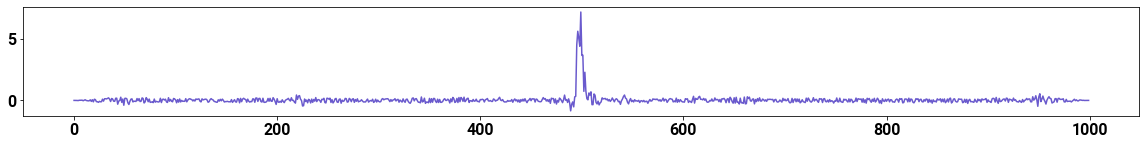

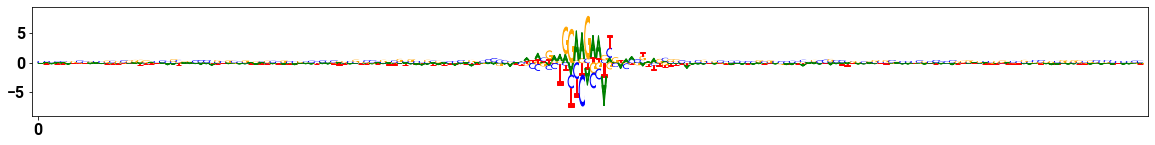

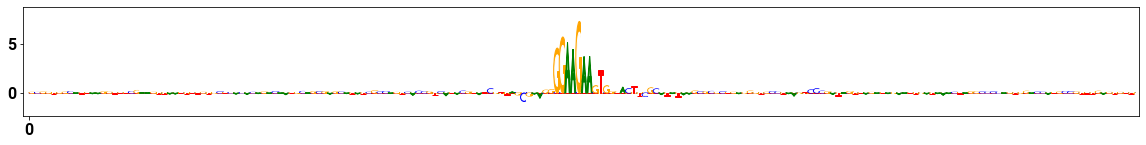

33
Without priors:


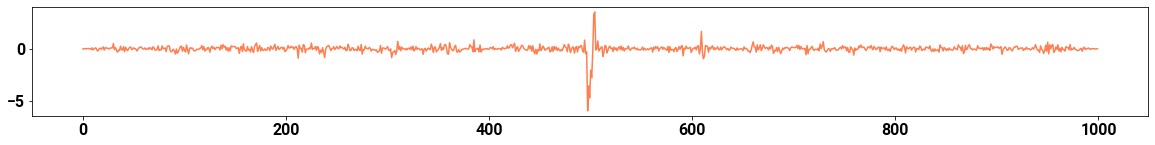

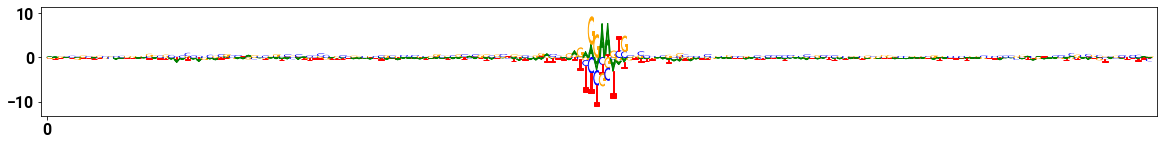

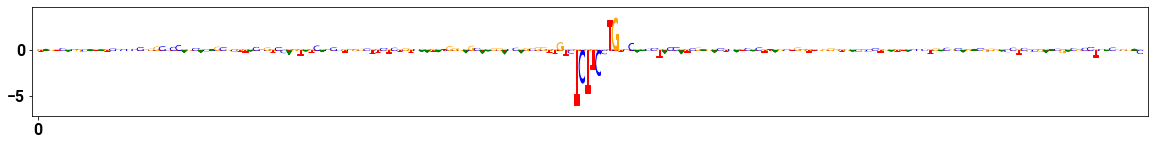

With priors:


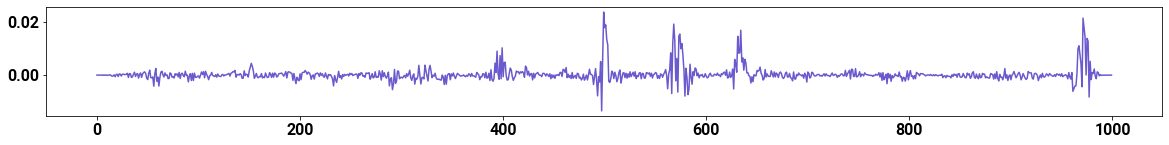

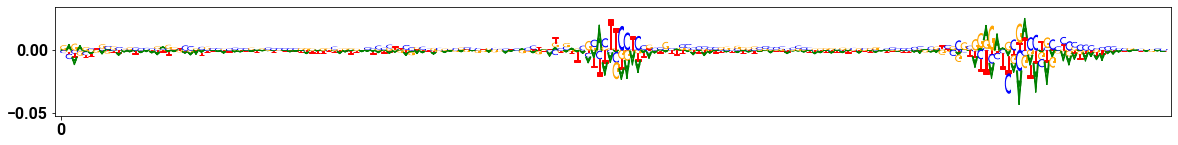

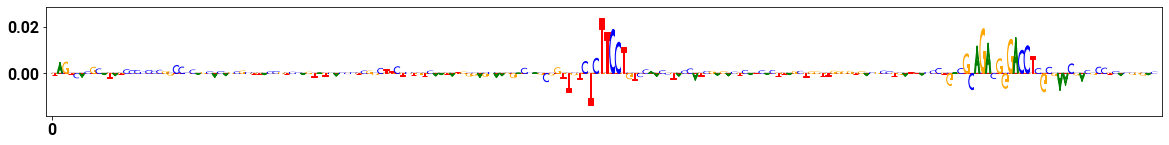

In [25]:
# Plot out a few examples
for i in np.random.choice(num_samples, size=3, replace=False):
    show_example(i, center_slice=slice(400, 600))